# 0. Install Dependencies and Bring in Data

In [1]:
!pip install tensorflow tensorflow-gpu pandas matplotlib sklearn

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached sklearn-0.0.post11-py3-none-any.whl
  Running setup.py clean for tensorflow-gpu
Failed to build tensorflow-gpu


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [18 lines of output]
  Traceback (most recent call last):
    File "<string>", line 2, in <module>
    File "<pip-setuptools-caller>", line 34, in <module>
    File "C:\Users\Uzair\AppData\Local\Temp\pip-install-st8jj1e7\tensorflow-gpu_84827143c7c44e83b18720db88f0b74e\setup.py", line 37, in <module>
      raise Exception(TF_REMOVAL_WARNING)
  Exception:
  
  The "tensorflow-gpu" package has been removed!
  
  Please install "tensorflow" instead.
  
  Other than the name, the two packages have been identical
  since TensorFlow 2.1, or roughly since Sep 2019. For more
  information, see: pypi.org/project/tensorflow-gpu
  
  
  [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tensorflow-gpu
ERROR: Could not build wheels for tensorflow-gpu, which is required to install pyproject.toml-

In [2]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [4]:
df = pd.read_csv(os.path.join('jigsaw-toxic-comment-classification-challenge','train.csv', 'train.csv'))

In [5]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\r\nWhy the edits made under my use...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\r\nMore\r\nI can't make any real suggestions...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# 1. Preprocess

In [6]:
!pip list

Package                      Version
---------------------------- ------------
absl-py                      2.0.0
aiofiles                     23.2.1
altair                       5.1.2
annotated-types              0.6.0
anyio                        3.7.1
argon2-cffi                  23.1.0
argon2-cffi-bindings         21.2.0
arrow                        1.3.0
asttokens                    2.4.1
astunparse                   1.6.3
async-lru                    2.0.4
attrs                        23.1.0
Babel                        2.13.1
beautifulsoup4               4.12.2
bleach                       6.1.0
cachetools                   5.3.2
certifi                      2023.7.22
cffi                         1.16.0
charset-normalizer           3.2.0
click                        8.1.6
colorama                     0.4.6
comm                         0.2.0
contourpy                    1.2.0
cycler                       0.12.1
debugpy                      1.8.0
decorator                    5.1.1

In [7]:
from tensorflow.keras.layers import TextVectorization

In [8]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [9]:
MAX_FEATURES = 25000 # number of words in the vocab

In [10]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=500,
                               output_mode='int')

In [11]:
vectorizer.adapt(X.values)

In [12]:
vectorized_text = vectorizer(X.values)

In [13]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(8)
dataset = dataset.prefetch(4) # helps bottlenecks

In [14]:
train = dataset.take(int(len(dataset)*.3))
val = dataset.skip(int(len(dataset)*.3)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.4)).take(int(len(dataset)*.1))

# 2. Create Sequential Model

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [16]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))

In [17]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          800032    
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [19]:
history = model.fit(train, epochs=1, validation_data=val)

5984/5984 [==============================] - 2782s 464ms/step - loss: 0.0709 - val_loss: 0.0535


In [20]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

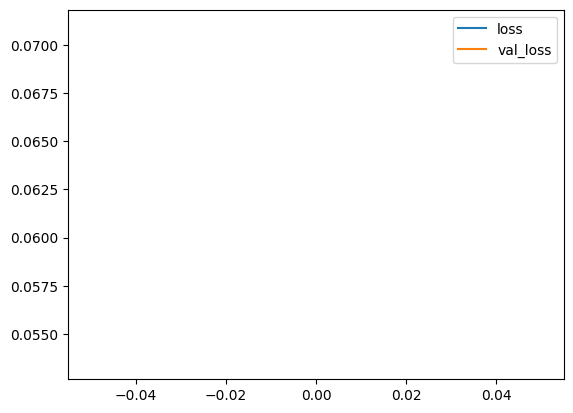

In [21]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# 3. Make Predictions

In [24]:
input_text = vectorizer('You freaking suck! I am going to hit you.')

In [25]:
input_text = ['You freaking suck! I am going to hit you']

# Vectorize the input text
vectorized_input = vectorizer(input_text)

# Reshape the input to match the expected shape (add batch dimension)
vectorized_input = tf.reshape(vectorized_input, [1, -1])

# Now, you can predict the toxicity for the input text
res = model.predict(vectorized_input)

# The 'res' variable will contain the model's predictions

1/1 [==============================] - 1s 910ms/step


In [26]:
(res > 0.5).astype(int)

array([[1, 0, 1, 0, 1, 0]])

In [27]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [28]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 0s 76ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [29]:
res.shape

(1, 6)

# 4. Evaluate Model

In [30]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [31]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [32]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 68ms/step


In [33]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.8478260636329651, Recall:0.625, Accuracy:0.43831494450569153


# 5. Test and Gradio

In [34]:
!pip install gradio jinja2

In [35]:
import tensorflow as tf
import gradio as gr

In [36]:
model.save('toxicity.h5')

C:\Users\Uzair\venv\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [37]:
model = tf.keras.models.load_model('toxicity.h5')

In [38]:
input_str = vectorizer('hey i freaken hate you!')

In [39]:
res = model.predict(np.expand_dims(input_str,0))

1/1 [==============================] - 1s 978ms/step


In [40]:
res

array([[0.74578863, 0.00920799, 0.2204957 , 0.0091073 , 0.36772528,
        0.03170235]], dtype=float32)

In [41]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

In [44]:
pip install gradio

In [47]:
import gradio as gr

interface = gr.Interface(
    fn=score_comment, 
    inputs="text", 
    outputs="text"
)

In [48]:
interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://2e90f2ee943855f4e6.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 [==============================] - 0s 55ms/step
